## Assignment 11 - Assembly of the stiffness matrix and first results

In this assignment we will assemble the stiffness matrix for our model problem and then, together with the results from assignment 10, solve the resulting linear system. <br>
Consider again Poisson's equation
$$ -\Delta u = f  \text{ in }\Omega$$
with Dirichlet boundary conditions
$$ u \equiv 0 \text{ on }\delta\Omega. $$
The discrete weak form of the problem is given by <br> <br>
<center>Find $U_j\in \mathbb{R}$ for $j=1,\dots,N_{DOF}$ such that 
$$ \sum\limits_{j=1}^{N_{DOF}} U_j \underbrace{\int_\Omega \nabla \phi_j \cdot \nabla \phi_i}_{=S_{ij}} = \underbrace{\int_\Omega f \phi_i}_{l_i}$$
holds for all $i=1,\dots,N_{DOF}$.</center> <br>
Doing the same process as for the load vector - with the difference that a use of the chain rule is required when transforming gradients (see assignment 4) - we arrive at the following derivation:
$$ S_{ij} = \int_\Omega \nabla \phi_j(x) \cdot \nabla \phi_i(x) \mathrm{d}x = \sum\limits_{T \in \tau_h} \int_T \nabla \phi_j(x) \cdot \nabla \phi_i(x) \mathrm{d}x= \sum\limits_{T \in supp(\phi_i) \cap supp(\phi_j)} \int_T \nabla \varphi_{\mathcal{D}_T(j)}^T(x) \cdot \nabla \varphi_{\mathcal{D}_T(i)}^T(x) \mathrm{d}x \\= \sum\limits_{T \in supp(\phi_i) \cap supp(\phi_j)} |\det D F_T| \int_{\hat{T}}  (DF_T)^{-*}\nabla\hat{\varphi}_{\mathcal{D}_T(j)}(\hat{x}) \cdot (DF_T)^{-*}\nabla \hat{\varphi}_{\mathcal{D}_T(i)}(\hat{x}) \mathrm{d} \hat{x} \\\approx\sum\limits_{T \in supp(\phi_i) \cap supp(\phi_j)}|\det D F_T| \sum\limits_{k=1}^{N_Q} \hat{w}_k (DF_T)^{-*}\nabla\hat{\varphi}_{\mathcal{D}_T(j)}(\hat{x}_k) \cdot (DF_T)^{-*}\nabla \hat{\varphi}_{\mathcal{D}_T(i)}(\hat{x}_k)$$

Download the Python classes <i>grid.py</i>, <i>basis.py</i> and <i>quadrature.py</i> and <b>place them in the same folder where this notebook is being executed</b>. Make yourself familiar with the classes and their methods - you know all of them from the previous assignments. Run the following block to generate an example setup:
<ul> 
<li> Triangular grid on $[0,1]^2$ with $4$ points in each direction</li>
<li> linear basis </li>
<li> quadrature of exactness $2$ </li>
<li> right-hand side source $f(x,y) = x + y$ </li>
</ul>

In [1]:
from grid import Grid
from quadrature import Quadrature
from basis import Basis 
import numpy as np

triangle = True

g = Grid(0,1,0,1,4,4,triangle)
q = Quadrature(2,triangle)
b = Basis(triangle)
f = lambda x,y: 1.0

### 11.1 - Stiffness Matrix assembly
Implement a function <b>assembleStiffnessMatrixDirichlet</b> that uses the derivation above and returns the stiffness matrix for Poisson's problem with homogenous Dirichlet boundary conditions. <br><br>
<b>INPUT:</b> $grid$ - a grid object, $quad$ - a quadrature object, $basis$ - a basis object<br>
<b>OUTPUT:</b> $S$ - the stiffness matrix <br><br>

Hint: The <i>grid</i> has now the additional functionality to return the indices of all inner points.

In [2]:
def assembleStiffnessMatrixDirichlet(grid, quad, basis):
    Nx,Ny = grid.getDivisions()
    innerIndices = grid.getInnerIndices()
    NDof = np.shape(innerIndices)[0]
    S = np.zeros((NDof,NDof))
    
    ### BEGIN SOLUTION
    rowIndex = 0
    columnIndex = 0
    
    # ---- Gather Data ----
    # dimension 3 x 2 and dimension 3 
    xkHat,wkHat = quad.getPointsAndWeights()
    # dimension Ncells x 2 x 3 -> 3 quad points for each cell
    xkTrafo = grid.evalReferenceMap(xkHat)
    # dimension Nc -> we do the absolute value now
    dets = np.abs(grid.getDeterminants())
    invJac = grid.getInverseJacobians()
    # values of basis functions can be recycled -> dimension Np x Nb x 2 = 3 x 3 x 2 
    gradPhi = basis.evalGradPhi(xkHat)    
    
    # ---- Loop over the degrees of freedom
    for i in range(Nx * Ny):
        # exclude boundary points
        if np.isin(i,innerIndices) == False: 
            continue
        columnIndex = 0
        for j in range(Nx * Ny):
            # exclude boundary points
            if np.isin(j,innerIndices) == False: 
                continue
            
            supp_I,localIndices_I = grid.evalDOFMap(i)
            supp_J,localIndices_J = grid.evalDOFMap(j)
                
            supp_IJ,tmpLocalIndices_I,tmpLocalIndices_J = np.intersect1d(supp_I,supp_J,assume_unique=False,return_indices=True)
            localIndices_I = localIndices_I[tmpLocalIndices_I]
            localIndices_J = localIndices_J[tmpLocalIndices_J]
            
            # T - cell index, m - local index in cell i, 
            for T,loc_i,loc_j in zip(supp_IJ,localIndices_I,localIndices_J):
                for k in range(xkHat.shape[0]):
                    S[rowIndex,columnIndex] += dets[T] * wkHat[k] * np.dot(np.dot(invJac[T,:,:],gradPhi[k,loc_j,:]),np.dot(invJac[T,:,:],gradPhi[k,loc_i,:]))
            columnIndex += 1 
        
        rowIndex += 1
    ### END SOLUTION
    return S

In [3]:
### BEGIN HIDDEN TESTS
assert (assembleStiffnessMatrixDirichlet(g,q,b)[0,0] - 4.0 < 1.e-3)
### END HIDDEN TESTS

In [4]:
### BEGIN HIDDEN TESTS
assert (assembleStiffnessMatrixDirichlet(g,q,b)[0,1] + 1.0 < 1.e-3)
### END HIDDEN TESTS

In [5]:
### BEGIN HIDDEN TESTS
assert (assembleStiffnessMatrixDirichlet(g,q,b)[0,2] + 1.0 < 1.e-3)
### END HIDDEN TESTS

In [6]:
### BEGIN HIDDEN TESTS
assert (assembleStiffnessMatrixDirichlet(g,q,b)[0,3]< 1.e-3)
### END HIDDEN TESTS

### 11.2 - Solving the Linear System
Use your implementation for the assembly of the stiffness matrix and the load vector assembly that is provided below to set up and solve the linear system for Poisson's equation with homogenous Dirichlet boundary conditions. Plot the solution - incorporating the boundary conditions - using the functionality of the provided <i>grid</i>.

In [7]:
def assembleLoadVectorDirichlet(grid, quad, basis, f):
    Nx,Ny = grid.getDivisions()
    innerIndices = grid.getInnerIndices()
    NDof = np.shape(innerIndices)[0]
    l = np.zeros(NDof)
    
    ind = 0
    # ---- Gather Data ----
    # dimension 3 x 2 and dimension 3 
    xkHat,wkHat = quad.getPointsAndWeights()
    # dimension Ncells x 2 x 3 -> 3 quad points for each cell
    xkTrafo = grid.evalReferenceMap(xkHat)
    # dimension Nc -> we do the absolute value now
    dets = np.abs(grid.getDeterminants())
    # values of basis functions can be recycled -> dimension Np x Nb = 3 x 3  
    phi = basis.evalPhi(xkHat) 
    
    # ---- Loop over the degrees of freedom
    for i in range(Nx * Ny):
        # exclude boundary points
        if np.isin(i,innerIndices) == False: 
            continue
            
        supp,localInd = grid.evalDOFMap(i)
        for T,j in zip(supp,localInd):
            l[ind] += dets[T] * np.sum(phi[:,j] * wkHat * f(xkTrafo[T,0,:],xkTrafo[T,1,:]))
        
        ind += 1

    return l

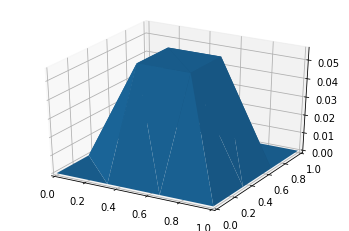

In [8]:
Nx,Ny = g.getDivisions()
u = np.zeros(Nx * Ny)

### BEGIN SOLUTION
S = assembleStiffnessMatrixDirichlet(g,q,b)
l = assembleLoadVectorDirichlet(g,q,b,f)
u[g.getInnerIndices()] = np.linalg.solve(S,l)
### END SOLUTION

g.plotDOFVector(u)